In [1]:
import subprocess
import os
print('Current conda environment:', os.environ['CONDA_DEFAULT_ENV'])
os.environ['TOKENIZERS_PARALLELISM'] = "false"

cwd = os.getcwd()
print(cwd)

import warnings
warnings.filterwarnings('ignore')

import random
random.seed(42)

Current conda environment: reinvent
/home/fts_g_ucla_edu/Projects/rips-relay/experiments


## Generating data from REINVENT, CReM, SAFE, and COATI

In [2]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})

from crem.crem import grow_mol, mutate_mol
crem_db = '../crem_db/crem_db2.5.db'

import mols2grid

from rdkit import Chem
from rdkit.Chem import AllChem, rdFingerprintGenerator, CanonSmiles, Draw, MolFromSmiles, PandasTools
from rdkit.Chem.rdmolops import RDKFingerprint
from rdkit import DataStructs
from rdkit.DataStructs.cDataStructs import BulkTanimotoSimilarity
import useful_rdkit_utils as uru

import safe as sf
import datamol as dm

import mols2grid

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch

from coati.generative.coati_purifications import embed_smiles
from coati.models.io.coati import load_e3gnn_smiles_clip_e2e
from coati.models.simple_coati2.io import load_coati2

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


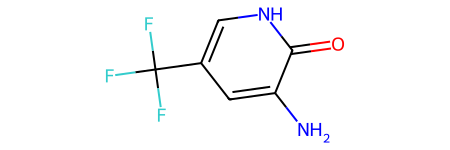

In [3]:
initial = 'Nc1cc(c[nH]c1=O)C(F)(F)F'
initial_mol = MolFromSmiles(initial)
initial_mol

In [4]:
def tanimoto_similarity(smi_1, smi_2, use_counts=True):
    fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048,countSimulation=True)
    mol_1 = Chem.MolFromSmiles(smi_1)
    mol_2 = Chem.MolFromSmiles(smi_2)
    if use_counts:
        fp_1 = rdFingerprintGenerator.GetCountFPs([mol_1])[0]
        fp_2 = rdFingerprintGenerator.GetCountFPs([mol_2])[0]
    else:
        fp_1 = rdFingerprintGenerator.GetFPs([mol_1])[0]
        fp_2 = rdFingerprintGenerator.GetFPs([mol_2])[0]
    return DataStructs.TanimotoSimilarity(fp_1, fp_2)

In [5]:
def remove_odd_rings(df):
    ring_system_lookup = uru.RingSystemLookup.default()
    df['ring_systems'] = df.SMILES.apply(ring_system_lookup.process_smiles)
    df[['min_ring','min_freq']] = df.ring_systems.apply(uru.get_min_ring_frequency).to_list()
    df = df.query('min_freq > 100').copy()
    return df.iloc[:, 0:3]

### Generating analogs w/ REINVENT

In [6]:
%cd ..

arg1 = f'--input_frag'
subprocess.run(['python3', 'generate_analogs.py', arg1, initial],
               stdout=subprocess.DEVNULL,
               stderr=subprocess.STDOUT)
        
# Change directory back to that of the current notebook
%cd experiments

/home/fts_g_ucla_edu/Projects/rips-relay
/home/fts_g_ucla_edu/Projects/rips-relay/experiments


In [8]:
df = pd.read_csv('data/reinvent_dataframe.csv')

df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [9]:
df = df.sample(n=500)
df['Model'] = 'reinvent'

df

,SMILES,Input_SMILES,Tanimoto,Prior,Model
900,Nc1cc(C2CCCCC2)c[nH]c1=O,Nc1cc(C(F)(F)F)c[nH]c1=O,0.428571,similarity,reinvent
50,N=c1[nH]cc(C(F)(F)F)cc1Cl,Nc1cc(C(F)(F)F)c[nH]c1=O,0.675676,high_similarity,reinvent
703,Cc1cc(C(F)(F)F)[nH]c(=O)c1,Nc1cc(C(F)(F)F)c[nH]c1=O,0.277778,scaffold,reinvent
671,CCc1c(C(C)C)c(C)[nH]c(=O)c1N,Nc1cc(C(F)(F)F)c[nH]c1=O,0.500000,scaffold_generic,reinvent
130,CCCNc1cc(C(F)(F)F)c[nH]c1=O,Nc1cc(C(F)(F)F)c[nH]c1=O,0.543478,medium_similarity,reinvent
...,...,...,...,...,...
176,Nc1nc(C(F)(F)F)c[nH]c1=O,Nc1cc(C(F)(F)F)c[nH]c1=O,0.400000,medium_similarity,reinvent
132,CCCc1c[nH]c(=O)c(N)c1,Nc1cc(C(F)(F)F)c[nH]c1=O,NaN,medium_similarity,reinvent
907,CCCCNc1cc(C(F)(F)F)c[nH]c1=O,Nc1cc(C(F)(F)F)c[nH]c1=O,0.512195,similarity,reinvent
55,N=c1[nH]cc(C(F)(F)F)cc1I,Nc1cc(C(F)(F)F)c[nH]c1=O,0.675676,high_similarity,reinvent


### Generating analogs w/ CReM

In [10]:
out_list = []
mutate_list = list(mutate_mol(initial_mol, db_name=crem_db, return_mol=False))

for idx, analog in enumerate(mutate_list):
    out_list.append([analog, initial])

In [11]:
temp_df = pd.DataFrame(out_list, columns=["SMILES","Input_SMILES"])

In [12]:
crem_smiles = temp_df['SMILES'].values

sim_to_initial = [tanimoto_similarity(smile, initial) for smile in crem_smiles]

In [13]:
temp_df['Tanimoto'] = sim_to_initial

temp_df = remove_odd_rings(temp_df)

temp_df['Model'] = 'crem'

In [14]:
temp_df.head()

,SMILES,Input_SMILES,Tanimoto,Model
0,FC(F)(F)c1nc2ccc(Br)cc2[nH]1,Nc1cc(c[nH]c1=O)C(F)(F)F,0.277778,crem
2,FC(F)(F)c1[nH]nc2ccccc12,Nc1cc(c[nH]c1=O)C(F)(F)F,0.264151,crem
3,FC(F)(F)c1nc2ccccc2[nH]1,Nc1cc(c[nH]c1=O)C(F)(F)F,0.264151,crem
4,FC(F)(F)c1ccccc1,Nc1cc(c[nH]c1=O)C(F)(F)F,0.288889,crem
5,FC(F)=C(F)CCSc1ccccn1,Nc1cc(c[nH]c1=O)C(F)(F)F,0.093750,crem


In [15]:
df = pd.concat((df, temp_df))

In [16]:
df

,SMILES,Input_SMILES,Tanimoto,Prior,Model
900,Nc1cc(C2CCCCC2)c[nH]c1=O,Nc1cc(C(F)(F)F)c[nH]c1=O,0.428571,similarity,reinvent
50,N=c1[nH]cc(C(F)(F)F)cc1Cl,Nc1cc(C(F)(F)F)c[nH]c1=O,0.675676,high_similarity,reinvent
703,Cc1cc(C(F)(F)F)[nH]c(=O)c1,Nc1cc(C(F)(F)F)c[nH]c1=O,0.277778,scaffold,reinvent
671,CCc1c(C(C)C)c(C)[nH]c(=O)c1N,Nc1cc(C(F)(F)F)c[nH]c1=O,0.500000,scaffold_generic,reinvent
130,CCCNc1cc(C(F)(F)F)c[nH]c1=O,Nc1cc(C(F)(F)F)c[nH]c1=O,0.543478,medium_similarity,reinvent
...,...,...,...,...,...
480,O=[N+]([O-])C=Cc1c(F)cc(Cl)cc1F,Nc1cc(c[nH]c1=O)C(F)(F)F,0.152542,NaN,crem
481,O=S(=O)(O)Oc1ccc(C(F)F)cc1,Nc1cc(c[nH]c1=O)C(F)(F)F,0.114754,NaN,crem
482,O=S(=O)(O)Oc1ccccc1C(F)F,Nc1cc(c[nH]c1=O)C(F)(F)F,0.114754,NaN,crem
483,Nc1cc(-c2ccccc2)c[nH]c1=O,Nc1cc(c[nH]c1=O)C(F)(F)F,0.339623,NaN,crem


### Generating analogs w/ COATI

In [17]:
encoder1, tokenizer1 = load_e3gnn_smiles_clip_e2e(
    freeze=True,
    device=torch.device("cuda:0"),
    doc_url="s3://terray-public/models/barlow_closed.pkl"
)

encoder2, tokenizer2 = load_coati2(
    freeze=True,
    device=torch.device("cuda:0"),
    doc_url="s3://terray-public/models/coati2_chiral_03-08-24.pkl"
)

Loading model from s3://terray-public/models/barlow_closed.pkl
Loading tokenizer may_closedparen from s3://terray-public/models/barlow_closed.pkl
number of parameters: 12.64M
number of parameters Total: 2.44M xformer: 17.92M Total: 20.36M 
vocab_name not found in tokenizer_vocabs, trying to load from file
Freezing encoder
20561664 params frozen!
Loading model from s3://terray-public/models/coati2_chiral_03-08-24.pkl
Loading tokenizer coati2_12_12 from s3://terray-public/models/coati2_chiral_03-08-24.pkl
number of parameters: 50.44M
number of parameters Total: xformer: 54.81M 
vocab_name not found in tokenizer_vocabs, trying to load from file
Freezing encoder
56385536 params frozen!


In [18]:
def gen_mol(smiles, coati_version=1, num_variations=100, noise_scale=0.15):

    # Embed the SMILES string
    smiles = CanonSmiles(smiles)

    if coati_version == 1:
        vector = embed_smiles(smiles, encoder1, tokenizer1)
    elif coati_version == 2:
        vector = embed_smiles(smiles, encoder2, tokenizer2)

    # Noise is added as an isotropic Gaussian with std=noise_scale
    if coati_version == 1:
        nearby_smiles = encoder1.hclip_to_2d_batch(
            h_clip=vector.unsqueeze(0).repeat(num_variations, 1),
            tokenizer=tokenizer1,
            noise_scale=noise_scale
        )
    elif coati_version == 2:
        nearby_smiles = encoder2.hcoati_to_2d_batch(
            h_coati=vector.unsqueeze(0).repeat(num_variations, 1),
            tokenizer=tokenizer2,
            noise_scale=noise_scale,
        )

    # Retrieve canonical SMILES of generated analogs
    unique_valid_smiles = list(set([CanonSmiles(smi) for smi in nearby_smiles if MolFromSmiles(smi)]))

    # Store true if original molecule is in the set of generated analogs
    had_orig = smiles in unique_valid_smiles

    unique_valid_smiles = list(set([smiles] + unique_valid_smiles))

    # Generate molecular fingerprints
    fp = RDKFingerprint(MolFromSmiles(smiles), minPath=1, maxPath=7, fpSize=2048)
    fps = [RDKFingerprint(MolFromSmiles(x), minPath=1, maxPath=7, fpSize=2048) for x in unique_valid_smiles]

    # Compute tanimoto similarities between distributions and store as list of strings
    sim = BulkTanimotoSimilarity(fp, fps)
    sim_str = [str(round(x, 2)) for x in sim]

    unique_valid_smiles, sim_str = zip(*sorted(zip(unique_valid_smiles, sim_str), key=lambda x:x[1], reverse=True))

    if not had_orig:
        unique_valid_smiles, sim_str = zip(*[[i, f"{j} (Added)"] if i==smiles else [i, j] for i, j in zip(unique_valid_smiles, sim_str)])

    # Output for molecule generation
    print (f"Attempted {num_variations} COATI{coati_version} generations with a noise scale of {noise_scale} and generated {len(unique_valid_smiles)} unique structures.")
    
    # Display molecules and tanimoto similarity to initial fragment
    # display(Draw.MolsToGridImage([MolFromSmiles(s) for s in unique_valid_smiles], molsPerRow=5, subImgSize=(200, 200), maxMols=100, legends=sim_str))
    
    return unique_valid_smiles

In [19]:
coati_smiles = gen_mol(initial, coati_version = 2, num_variations = 1000, noise_scale = 0.5)

Attempted 1000 COATI2 generations with a noise scale of 0.5 and generated 243 unique structures.


In [20]:
temp_df = pd.DataFrame()
temp_df['SMILES'] = coati_smiles
temp_df['Input_SMILES'] = initial

len(temp_df)

243

In [21]:
sim_to_initial = [tanimoto_similarity(smile, initial) for smile in coati_smiles]

temp_df['Tanimoto'] = sim_to_initial

temp_df = remove_odd_rings(temp_df)

temp_df['Model'] = 'coati'

len(temp_df)

186

In [22]:
temp_df.head()

,SMILES,Input_SMILES,Tanimoto,Model
0,Nc1cc(C(F)(F)F)c[nH]c1=O.Nc1ccc[nH]c1=O,Nc1cc(c[nH]c1=O)C(F)(F)F,0.584906,coati
1,Nc1cc(C(F)(F)F)c[nH]c1=O,Nc1cc(c[nH]c1=O)C(F)(F)F,1.000000,coati
2,N#CC=C[NH2+][O-].Nc1cc(C(F)(F)F)c[nH]c1=O,Nc1cc(c[nH]c1=O)C(F)(F)F,0.659574,coati
3,Nc1c[nH]c(=O)c(C(F)(F)F)c1,Nc1cc(c[nH]c1=O)C(F)(F)F,0.589744,coati
4,Cc1c[nH]c(=O)c(N)c1,Nc1cc(c[nH]c1=O)C(F)(F)F,0.486486,coati


In [23]:
df = pd.concat((df, temp_df))

In [24]:
df

,SMILES,Input_SMILES,Tanimoto,Prior,Model
900,Nc1cc(C2CCCCC2)c[nH]c1=O,Nc1cc(C(F)(F)F)c[nH]c1=O,0.428571,similarity,reinvent
50,N=c1[nH]cc(C(F)(F)F)cc1Cl,Nc1cc(C(F)(F)F)c[nH]c1=O,0.675676,high_similarity,reinvent
703,Cc1cc(C(F)(F)F)[nH]c(=O)c1,Nc1cc(C(F)(F)F)c[nH]c1=O,0.277778,scaffold,reinvent
671,CCc1c(C(C)C)c(C)[nH]c(=O)c1N,Nc1cc(C(F)(F)F)c[nH]c1=O,0.500000,scaffold_generic,reinvent
130,CCCNc1cc(C(F)(F)F)c[nH]c1=O,Nc1cc(C(F)(F)F)c[nH]c1=O,0.543478,medium_similarity,reinvent
...,...,...,...,...,...
225,Nc1nc(C(=O)C(F)(F)F)c[nH]1,Nc1cc(c[nH]c1=O)C(F)(F)F,0.377778,NaN,coati
226,Nc1n[nH]ccc1=O,Nc1cc(c[nH]c1=O)C(F)(F)F,0.204545,NaN,coati
238,N[C@@H]1C=C(C(F)(F)F)C(=O)C1,Nc1cc(c[nH]c1=O)C(F)(F)F,0.311111,NaN,coati
239,C=C(C)N1C(=O)C=CC1=O,Nc1cc(c[nH]c1=O)C(F)(F)F,0.117647,NaN,coati


### Generating analogs w/ SAFE

In [25]:
designer = sf.SAFEDesign.load_default(verbose=True)

designer.model

SAFEDoubleHeadsModel(
  (transformer): GPT2Model(
    (wte): Embedding(1880, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=1880, bias=False)
  (multiple_choice_head): PropertyHead(
    (summary): Linear(in_features=768, out_features=64, bias=True)
    

In [26]:
generated_smiles = designer.super_structure(
    core=initial,
    n_samples_per_trial=200,
    n_trials=1,
    sanitize=True,
    do_not_fragment_further=False,
    attachment_point_depth=3,
)

generated_smiles

  0%|          | 0/1 [00:00<?, ?it/s]

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - Pand

['Nc1c(C(F)(F)F)c(C(F)(F)F)c(C(F)(F)F)[nH]c1=O',
 'Nc1c(C(F)(F)F)c(C(F)(F)F)c(C(F)(F)F)[nH]c1=O',
 'Nc1c(C(F)(F)F)c(C(F)(F)F)c(C(F)(F)F)[nH]c1=O',
 'Nc1c(C(F)(F)F)c(C(F)(F)F)c(C(F)(F)F)[nH]c1=O',
 'Nc1c(C(F)(F)F)c(C(F)(F)F)c(C(F)F)[nH]c1=O',
 'Nc1c(C(F)F)c(C(F)(F)F)c(C(F)(F)F)[nH]c1=O',
 'Nc1c(C(F)F)c(C(F)(F)F)c(C(F)(F)Cl)[nH]c1=O',
 'Nc1c(S(N)(=O)=O)c(C(F)(F)F)c(C(F)(F)F)[nH]c1=O',
 'Nc1c(CBr)c(C(F)(F)F)c(C(F)(F)F)[nH]c1=O',
 'Nc1c(C(F)(F)F)c(C(F)(F)F)c(C(F)F)[nH]c1=O',
 'Nc1c(C(F)(F)F)c(C(F)(F)F)c(C(F)(F)F)[nH]c1=O',
 'Nc1c(C(F)(F)F)c(C(F)(F)F)c(C(F)(F)F)[nH]c1=O',
 'Nc1c(C(F)(F)F)c(C(F)(F)F)c(C(F)(F)F)[nH]c1=O',
 'Nc1c(CF)c(C(F)(F)F)c(C(F)(F)F)[nH]c1=O',
 'Nc1c(C(F)(F)F)c(C(F)(F)F)c(C(F)(F)F)[nH]c1=O',
 'Nc1c(C(F)(F)F)c(C(F)(F)F)c(C(F)(F)F)[nH]c1=O',
 'Nc1c(C(F)(F)F)c(C(F)(F)F)c(C(F)(F)F)[nH]c1=O',
 'Nc1c(C(F)(F)F)c(C(F)(F)F)c(C(F)(F)F)[nH]c1=O',
 'Nc1c(C(F)(F)F)c(C(F)(F)F)c(C(F)(F)F)[nH]c1=O',
 '[N-]=[N+]=Nc1c(C(F)(F)F)c([N+](=O)[O-])[nH]c(=O)c1N',
 'Nc1c(C(F)(F)F)c(C(F)(F)F)c(C(F)

In [28]:
temp_df = pd.DataFrame()
temp_df['SMILES'] = generated_smiles
temp_df['Input_SMILES'] = initial

In [29]:
len(temp_df)

200

In [31]:
sim_to_initial = [tanimoto_similarity(smile, initial) for smile in generated_smiles]

temp_df['Tanimoto'] = sim_to_initial

temp_df = remove_odd_rings(temp_df)

temp_df['Model'] = 'safe'

len(temp_df)

199

In [32]:
df = pd.concat((df, temp_df))

In [33]:
df

,SMILES,Input_SMILES,Tanimoto,Prior,Model
900,Nc1cc(C2CCCCC2)c[nH]c1=O,Nc1cc(C(F)(F)F)c[nH]c1=O,0.428571,similarity,reinvent
50,N=c1[nH]cc(C(F)(F)F)cc1Cl,Nc1cc(C(F)(F)F)c[nH]c1=O,0.675676,high_similarity,reinvent
703,Cc1cc(C(F)(F)F)[nH]c(=O)c1,Nc1cc(C(F)(F)F)c[nH]c1=O,0.277778,scaffold,reinvent
671,CCc1c(C(C)C)c(C)[nH]c(=O)c1N,Nc1cc(C(F)(F)F)c[nH]c1=O,0.500000,scaffold_generic,reinvent
130,CCCNc1cc(C(F)(F)F)c[nH]c1=O,Nc1cc(C(F)(F)F)c[nH]c1=O,0.543478,medium_similarity,reinvent
...,...,...,...,...,...
195,Nc1c(C(F)(F)F)c(C(F)(F)F)c(C(F)(F)F)[nH]c1=O,Nc1cc(c[nH]c1=O)C(F)(F)F,0.269841,NaN,safe
196,Nc1c(C(F)(F)F)c(C(F)(F)F)c(C(F)(F)F)[nH]c1=O,Nc1cc(c[nH]c1=O)C(F)(F)F,0.269841,NaN,safe
197,Nc1c(C(=O)O)c(C(F)(F)F)c(C(F)(F)F)[nH]c1=O,Nc1cc(c[nH]c1=O)C(F)(F)F,0.278689,NaN,safe
198,Nc1c(C(F)(F)F)c(C(F)(F)F)c(C(F)(F)F)[nH]c1=O,Nc1cc(c[nH]c1=O)C(F)(F)F,0.269841,NaN,safe


## Visualizing the models in chemical space

### PCA

In [34]:
smiles = df['SMILES'].values
mols = [MolFromSmiles(smile) for smile in smiles]

In [35]:
fpgen = AllChem.GetMorganGenerator()

fingerprints = [fpgen.GetFingerprint(mol).ToList() for mol in mols]

In [36]:
df['Fingerprints'] = fingerprints

In [37]:
X = fingerprints

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [38]:
pca = PCA(n_components=3, random_state=0)
pca_fps = pca.fit_transform(X)

In [39]:
var1, var2, var3 = pca.explained_variance_ratio_

In [40]:
df['PC1'], df['PC2'], df['PC3'] = pca_fps.T[0], pca_fps.T[1], pca_fps.T[2]

In [41]:
plot_df = df.sample(n=500)

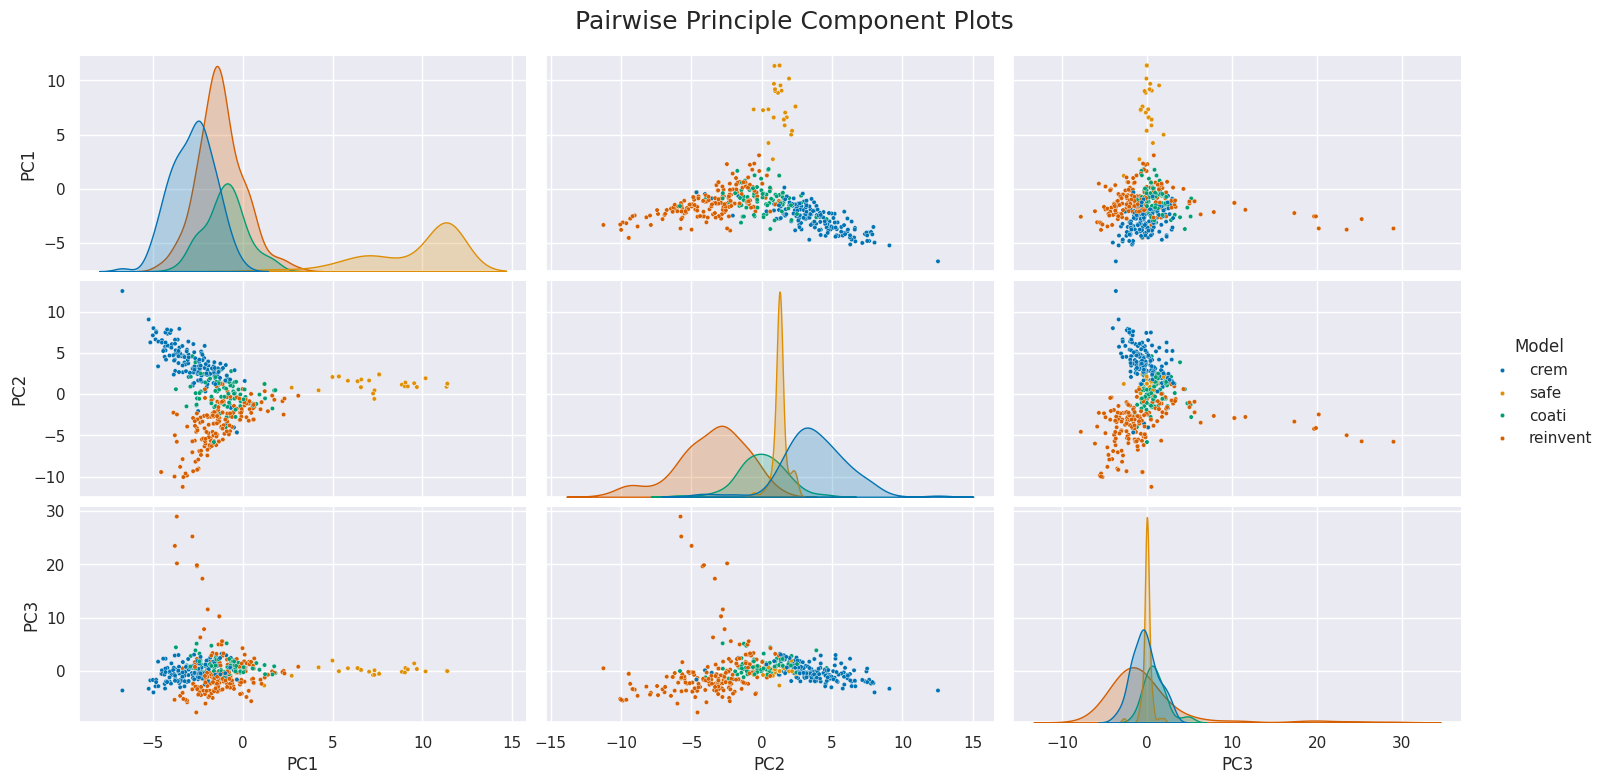

In [42]:
f = sns.pairplot(plot_df,
                 hue='Model',
                 vars=['PC1', 'PC2', 'PC3'],
                 palette='colorblind',
                 aspect=2,
                 plot_kws=dict(s=10))

f.fig.suptitle('Pairwise Principle Component Plots', fontsize=18, y=1.04);

### t-SNE

In [47]:
p = 100

pca_model = PCA(n_components=5, random_state=0)
tsne_model = TSNE(n_components=2, random_state=0, perplexity=p, n_iter=5000)
tsne_fps = tsne_model.fit_transform(pca_model.fit_transform(X))

In [48]:
df['TSNE1'], df['TSNE2'] = tsne_fps.T[0], tsne_fps.T[1]

In [49]:
plot_df = df.sample(n=500)

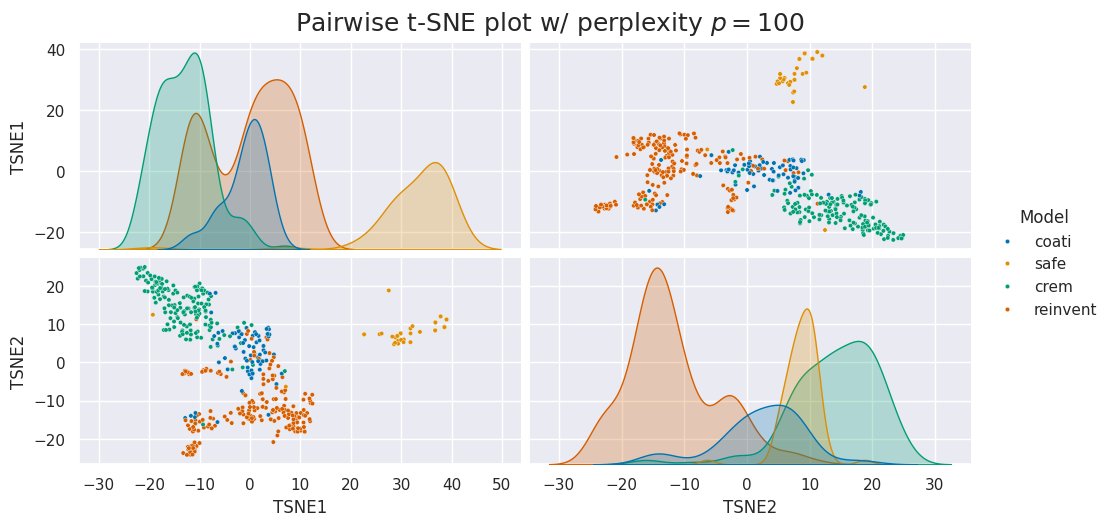

In [50]:
f = sns.pairplot(plot_df,
                 hue='Model',
                 vars=['TSNE1', 'TSNE2'],
                 palette='colorblind',
                 aspect=2,
                 plot_kws=dict(s=10))

title = f'Pairwise t-SNE plot w/ perplexity $p={p}$'

f.fig.suptitle(title, fontsize=18, y=1.04);